# Imports

In [172]:
import numpy as np
from recode import decode_pcm_bytes

from functools import partial
from more_itertools import take 
from audiostream2py.file import WavFileSourceReader
from audiostream2py.data import AudioSegment # switch to other branch

from sklearn.utils import check_X_y, check_array


def audio_plc_gen(accel_source, plc_source):
    # with accel_source.stream_buffer(maxlen=None) as accel_buffer:
    #     with plc_source.stream_buffer(maxlen=None) as plc_buffer:
            # accel_reader = accel_buffer.mk_reader()
            # plc_reader = plc_buffer.mk_reader()
            # next_audio = partial(accel_reader.next, ignore_no_item_found=True)
            # next_plc = partial(plc_reader.next, ignore_no_item_found=True)
    with accel_source:
        with plc_source:
            while True:
                # audio = next_audio()
                # plc = next_plc()
                audio = accel_source.read()
                plc = plc_source.read()
                yield audio, plc

plc_file = '../data/PLC.wav'
accel_file = '../data/1621346260226336_ch2.wav'

plc_source = WavFileSourceReader(plc_file, frames_per_buffer=50, start_date=0) #frames per buffer was 5 
accel_source = WavFileSourceReader(accel_file, frames_per_buffer=12800, start_date=0)

from audiostream2py.file import file_to_audio_segment
wf_segment = file_to_audio_segment(file=accel_file)



In [173]:
# my_gen = audio_plc_gen(accel_source, plc_source)
# for _ in range(300):
#     audio, plc = next(my_gen)
#     #plc = plc_source.read()
#     #audio = accel_source.read()
#     print(plc, audio)

# Using dags

In [252]:
from creek.automatas import BasicAutomata, mapping_to_transition_func
from typing import Callable, MutableMapping, Any, Mapping, Literal
from dataclasses import dataclass
from i2 import ch_names
from pprint import pprint
import numpy as np
from creek import BufferStats
from statistics import mean
from collections import deque

Case = Any
Cases = Mapping[Case, Callable]


RecordingCommands = Literal["start", "resume", "stop"]

def get_bytes_of_audio_segment(audio_segment: AudioSegment) -> bytes:
    return audio_segment.waveform

def convert_bytes_to_array(bytes_: bytes, dtype: type) -> np.ndarray:
    return np.frombuffer(bytes_, dtype=dtype)

def convert_array_to_bool(array: np.ndarray) -> np.ndarray:
    return array != 0 

def audio_segment_to_int(audio_segment: AudioSegment) -> np.ndarray:
    bytes_ = get_bytes_of_audio_segment(audio_segment)
    array = convert_bytes_to_array(bytes_, dtype=np.int16)
    bool_array = convert_array_to_bool(array)
    int_array = bool_array.astype(np.int8)
    return list(int_array)

def plc_segment_to_bool(plc_segment: AudioSegment) -> np.ndarray:
    return np.array(decode_pcm_bytes(plc_segment.waveform))

def get_audio_ts_from_index(audio_segment: AudioSegment, index: int) -> tuple:
    return audio_segment.get_ts_of_frame_index(index)

def get_bt_of_ts(ts: tuple):
    return ts[0]

edges_ones_idx = lambda edges: [i for i, x in enumerate(edges) if x == 1],
ts_for_edge_one = lambda edges_ones_idx, plc_segment: [get_audio_ts_from_index(plc_segment, i) for i in edges_ones_idx],

@dataclass
class RecordingSwitchBoard:
    store: MutableMapping = None
    _current_key = None

    def start(self, key, chk):
        self._current_key = key
        self.store[key] = []
        self._append(chk)

    def resume(self, key, chk):
        print(f'resume called')
        self._append(chk)

    def stop(self, key, chk):
        self._append(chk)
        self._current_key = None

    def _append(self, chk):
        if self._current_key is None:
            raise ValueError("Cannot append without first starting recording.")
        self.store[self._current_key].extend(chk)

    @property
    def is_recording(self):
        return self._current_key is not None


@dataclass
class SimpleSwitchCase:
    """A functional implementation of thw switch-case control flow.
    Makes a callable that takes two arguments, a case and an input.

    >>> f = SimpleSwitchCase({'plus_one': lambda x: x + 1, 'times_two': lambda x: x * 2})
    >>> f('plus_one', 2)
    3
    >>> f('times_two', 2)
    4
    """

    cases: Mapping[Case, Callable]

    def __call__(self, case, input):
        func = self.cases.get(case, None)
        if func is None:
            raise ValueError(f"Case {case} not found.")
        return func(input)


def mk_simple_switch_case(
    cases: Cases, *, name: str = None, case_name: str = None, input_name: str = None
):
    """
    Makes a simple switch-case function, with optional naming control.
    """
    switch_case_func = SimpleSwitchCase(cases)
    switch_case_func = ch_names(
        switch_case_func, **dict(case=case_name, input=input_name)
    )
    if name is not None:
        switch_case_func.__name__ = name
    return switch_case_func


def mk_recorder_switch(
    store, *, mk_recorder: Callable[[MutableMapping], Any] = RecordingSwitchBoard
):
    recorder = mk_recorder(store)
    return mk_simple_switch_case(
        {
            "start": lambda key_and_chk: recorder.start(*key_and_chk),
            "resume": lambda key_and_chk: recorder.resume(*key_and_chk),
            "stop": lambda key_and_chk: recorder.stop(*key_and_chk),
            "waiting": lambda x: None,
        },
        name="recorder_switch",
        case_name="state",
        input_name="key_and_chk",
    )


def mk_transition_func(
    trans_func_mapping,
    initial_state,  # symbol_var_name: str,
):
    recording_state_transition_func = mapping_to_transition_func(
        trans_func_mapping,
        strict=False,
    )
    transitioner = BasicAutomata(
        transition_func=recording_state_transition_func,
        state=initial_state,
    )

    # @i2.ch_names(symbol=symbol_var_name)
    def transition(symbol):
        return transitioner.transition(symbol)

    # transition = transitioner.reset().transition

    return transition

class AudioSegmentProcessorOld:
    write_state = False
    buffered_segment = [AudioSegment.empty()] # [] is better

    def __call__(self, segment, ts=None):
        if isinstance(ts, list):
            ts = ts[0]
        if (not self.write_state) and ts is None:
            return None
        if (not self.write_state) and ts:
            self.buffered_segment = [segment[ts:]]
            self.write_state = True
        if self.write_state and ts is None:
            self.buffered_segment += [segment]
        if self.write_state and ts:
            result = self.buffered_segment + [segment[:ts]]
            self.buffered_segment = [segment[ts:]]
            return result

def sum_none(a,b):
    if a is None:
        return b
    if b is None:
        return a
    return a + b
    

class AudioSegmentProcessor_addition:
    write_state = False
    buffered_segment = None 

    def __call__(self, segment, ts=None):
        if isinstance(ts, list):
            ts = ts[0]
        if (not self.write_state) and ts is None:
            return None
        elif (not self.write_state) and ts:
            self.buffered_segment = segment[ts:]
            self.write_state = True
        elif self.write_state and ts is None:
            self.buffered_segment = sum_none(self.buffered_segment, segment)
        elif self.write_state and ts:
            result = sum_none(self.buffered_segment ,segment[:ts])
            self.buffered_segment = segment[ts:]
            return result

class AudioSegmentProcessor:
    write_state = False
    buffered_segment = AudioSegment.empty() # use something more general

    def __call__(self, segment, ts=None):
        if isinstance(ts, list):
            ts = ts[0]
        if (not self.write_state) and ts is None:
            return None
        elif (not self.write_state) and ts:
            self.buffered_segment = segment[ts:]
            self.write_state = True
            return None
        elif self.write_state and ts is None:
            self.buffered_segment = AudioSegment.concatenate([self.buffered_segment, segment])
            return None
        elif self.write_state and ts:
            result = AudioSegment.concatenate([self.buffered_segment , segment[:ts]])
            self.buffered_segment = segment[ts:]
            return result




def mk_audio_segment_processor():
    return AudioSegmentProcessor()

def rising(d):
    x,y=d
    return int(x<y)

def mk_event_detector(values=(0,), maxlen=2, func=rising):
    bs = BufferStats(values = values,maxlen=maxlen, func=func) 
    def detector(segment):
        return [bs(item) for item in segment]
    return detector

def append_if_not_none(l, item):
    if not item is None:
        l.append(item)

    return l


def mk_buffer(values =(0.,),maxlen=5, func=mean, add_new_val=deque.append):
    bs = BufferStats(values=values,maxlen=maxlen, func=func, add_new_val=add_new_val) 
    return bs

def flatten(l):
    res = []
    for item in l:
        if isinstance(item, list):
            res.extend(item)
        else:
            res.append(item)
    return res

def plot_rising_edges(wf_segment, ts_list):
    import matplotlib.pyplot as plt

    frames = [wf_segment._nearest_frame_index(ts) for ts in ts_list if ts]

    x_max = max(frames)
    _, ax = plt.subplots(1,1, figsize=(20,10))
    ax.plot(convert_bytes_to_array(wf_segment.waveform, dtype=np.int16)[:x_max])
    for frame in frames:
        ax.axvline(x=frame,color='r')
    plt.show()


# simple model
from scipy import special
from sklearn.preprocessing import StandardScaler

def cdf(x, mu, sigma):
    return  1./2 + 1./2*special.erf((np.log(x)-mu)/(np.sqrt(2)*sigma))

def log_normal_pdf(x, mu, sigma):
    return np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi))

def check_arr(X):
    try:
        check_array(X, ensure_2d=True)
    except ValueError:
        return X.reshape(-1,1)

class LogNormal:
    def __init__(self) -> None:
        self.scaler = StandardScaler()
    
    def fit(self, X):

        self.partial_fit(X)
        return self

    def partial_fit(self, X):
        X=check_arr(X)
        self.scaler.partial_fit(np.log(X))
        self.mu= self.scaler.mean_
        self.sigma = self.scaler.scale_

        return self

    def predict(self, X):
        return cdf(X, self.mu, self.sigma)

def mk_model():
    return LogNormal()
# trans_func_mapping = {
#     ("waiting", 1): "start",
#     ("start", 0): "resume",
#     ("start", 1): "stop",
#     ("resume", 1): "stop",
#     ("stop", 0): "waiting",
#     ("stop", 1): "start",
# }

# trans_func_mapping = {
#     ("w", 1): "n",
#     ("n", 0): "c",
#     #("n", 1): "c",
#     ("c", 1): "n",
#     #("c", 0): "w",
#     #("stop", 0): "start",
#     #("stop", 1): "start",
# }
trans_func_mapping = {
    (0, 1): 1,
    (1, 1): 0,
    (1, 0): 0,
    (0, 0): 0,
    #("c", 0): "w",
    #("stop", 0): "start",
    #("stop", 1): "start",
}
plc_symbols = ['00', '01', '10', '11'] # ['a', 'b', 'c', 'd']

In [253]:
from meshed import DAG
from meshed.dag import parametrized_dag_factory


# object storing state information
#store = dict()
event_detector = mk_event_detector()
ap = mk_audio_segment_processor()
buffer_5 = mk_buffer(maxlen=5, func=mean, add_new_val = append_if_not_none)
model = mk_model()

# debug timestamps
debug_ts = []
debug_preds =[]
# definition of the dag
dag = DAG.from_funcs(
    int_segment = lambda plc_segment: audio_segment_to_int(plc_segment),
    edges = lambda int_segment: event_detector(int_segment), #segment of same size, with edges indicated
    edges_ones_idx = lambda edges: [i for i, x in enumerate(edges) if x == 1], #indices of edges occuring
    ts_for_edge_one = lambda edges_ones_idx, plc_segment: [get_bt_of_ts(get_audio_ts_from_index(plc_segment, i)) for i in edges_ones_idx] or None,
    ts_debug = lambda ts_for_edge_one: debug_ts.append(ts_for_edge_one),
    audio_segment = lambda audio, ts_for_edge_one: ap(audio, ts_for_edge_one),
    audio_waveform = lambda audio_segment: convert_bytes_to_array(audio_segment.waveform, dtype=np.int16) if audio_segment else None,
    std_audio_segment = lambda audio_waveform: np.std(audio_waveform) if (not audio_waveform is None) else None,
    fvs = lambda std_audio_segment: buffer_5(std_audio_segment), #outputting the mean
    fitted_model = lambda fvs: model.fit(np.array(fvs)+1), # hack to avoid log(0)  
    preds = lambda fitted_model, fvs: fitted_model.predict(np.array(fvs)+1), # hack to avoid log(0)
    result_debug = lambda preds: debug_preds.append(preds),

)

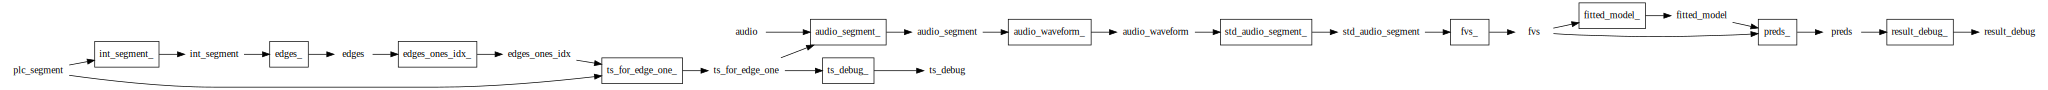

In [254]:
# start_lines means actually a preamble!
dag.dot_digraph(start_lines='rankdir=LR')

In [255]:
# run the dag
DFLT_NUM_SEGMENTS = 100
plc_source = WavFileSourceReader(plc_file, frames_per_buffer=50, start_date=0)
accel_source = WavFileSourceReader(accel_file, frames_per_buffer=12800, start_date=0)
my_gen = audio_plc_gen(accel_source, plc_source)

for _ in range(DFLT_NUM_SEGMENTS):
    audio, plc = next(my_gen)
    result = dag(plc_segment=plc , audio =audio)
    print(f' -------> released_std={result}')
    

 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None, None)
 -------> released_std=(None

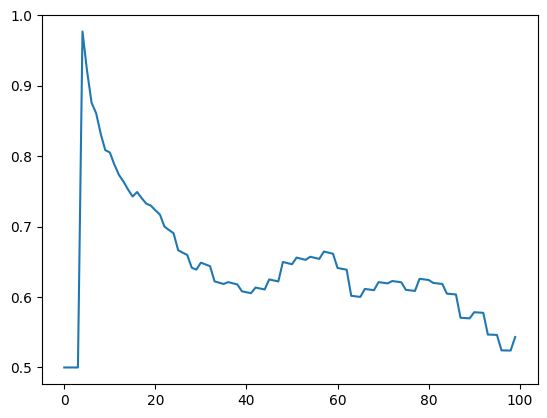

In [256]:
# observe values
plt.plot(np.array(debug_preds).reshape(-1,))

In [257]:
print(dag.synopsis_string())

plc_segment -> int_segment_ -> int_segment
int_segment -> edges_ -> edges
edges -> edges_ones_idx_ -> edges_ones_idx
edges_ones_idx,plc_segment -> ts_for_edge_one_ -> ts_for_edge_one
ts_for_edge_one -> ts_debug_ -> ts_debug
audio,ts_for_edge_one -> audio_segment_ -> audio_segment
audio_segment -> audio_waveform_ -> audio_waveform
audio_waveform -> std_audio_segment_ -> std_audio_segment
std_audio_segment -> fvs_ -> fvs
fvs -> fitted_model_ -> fitted_model
fitted_model,fvs -> preds_ -> preds
preds -> result_debug_ -> result_debug


In [258]:
from meshed.dag import parametrized_dag_factory


learning_dag = DAG.from_funcs(
    learned_model = lambda fvs, model: model.fit(fvs)
)

apply_model_dag = DAG.from_funcs(
    predicted = lambda fvs, fitted_model: fitted_model.predict(fvs)
)

ddag = dag+learning_dag

parametrized_learner = parametrized_dag_factory(ddag, 'model')
from i2 import Sig
Sig(parametrized_learner), Sig(ddag)

(<Sig ()>, <Sig (plc_segment, audio, model)>)

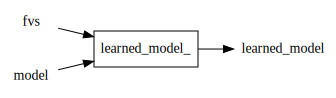

In [259]:
learning_dag.dot_digraph(start_lines='rankdir=LR')

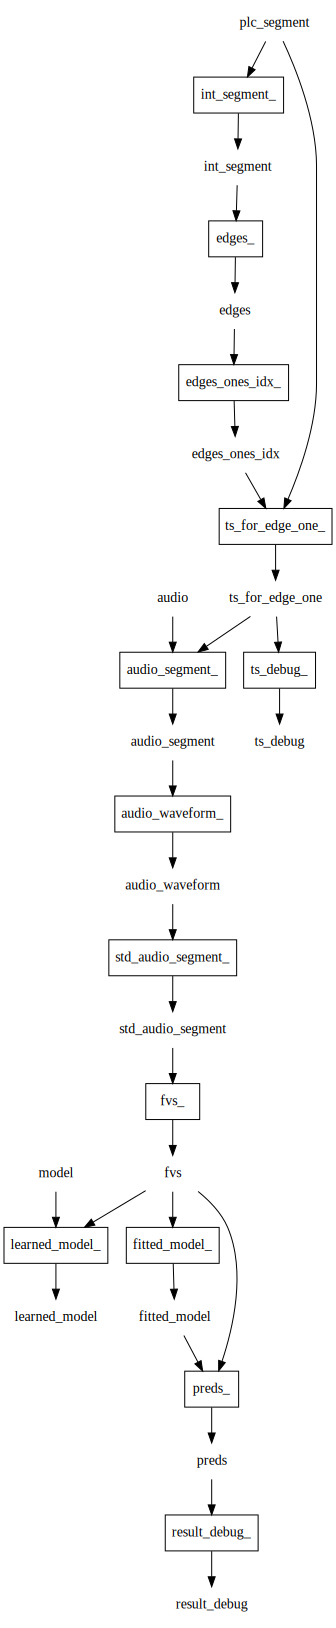

In [260]:
ddag = dag+learning_dag
ddag.dot_digraph()

In [261]:
# the classifier for stamping press:
# log_normal distribution
#estimate the mu, sigma
# then compute the value
# compare with a threshold

# or use Stroll with one centroid only may be,
# make dag template or a class for that

# Visualizing the results

In [262]:
from audiostream2py.file import file_to_audio_segment
wf_segment = file_to_audio_segment(file=accel_file)

In [263]:
plot_rising_edges(wf_segment, debug_ts)

TypeError: unsupported operand type(s) for -: 'list' and 'int'

# Using parametrized dags

In [264]:
from meshed import DAG
from meshed.dag import parametrized_dag_factory


# object storing state information
#store = dict()
# event_detector = mk_event_detector()
# ap = mk_audio_segment_processor()
# buffer_5 = mk_buffer(maxlen=5, func=mean, add_new_val = append_if_not_none)

# debug timestamps
debug_ts = []

# definition of the dag
dag = DAG.from_funcs(
    event_detector = lambda dummy_x: mk_event_detector(),
    ap = lambda dummy_a: mk_audio_segment_processor(),
    buffer_5 = lambda dummy_b: mk_buffer(maxlen=5, func=mean, add_new_val = append_if_not_none),
    int_segment = lambda plc_segment: audio_segment_to_int(plc_segment),
    edges = lambda int_segment, event_detector: event_detector(int_segment), #segment of same size, with edges indicated
    edges_ones_idx = lambda edges: [i for i, x in enumerate(edges) if x == 1], #indices of edges occuring
    ts_for_edge_one = lambda edges_ones_idx, plc_segment: [get_bt_of_ts(get_audio_ts_from_index(plc_segment, i)) for i in edges_ones_idx] or None,
    ts_debug = lambda ts_for_edge_one: debug_ts.append(ts_for_edge_one),
    audio_segment = lambda audio, ts_for_edge_one, ap: ap(audio, ts_for_edge_one),
    audio_waveform = lambda audio_segment: convert_bytes_to_array(audio_segment.waveform, dtype=np.int16) if audio_segment else None,
    std_audio_segment = lambda audio_waveform: np.std(audio_waveform) if (not audio_waveform is None) else None,
    fvs = lambda std_audio_segment, buffer_5: buffer_5(std_audio_segment), #outputting the mean
)
parametrized_dag = parametrized_dag_factory(dag, 'event_detector ap buffer_5')

In [265]:
dummy_dag = DAG.from_funcs(
    event_finder = lambda data, detector: mk_event_finder(data, detector),
    detector = lambda detector_params: mk_event_detector(detector_params),
)
parametrized_dag = parametrized_dag_factory(dummy_dag, 'event_finder')

In [266]:
parametrized_dag(detector=12)

TypeError: missing a required argument: 'detector_params'

In [267]:
from i2 import Sig
Sig(parametrized_dag(dummy_x=1, dummy_a=1, dummy_b=1))
ddag = parametrized_dag(dummy_x=1, dummy_a=1, dummy_b=1)

TypeError: missing a required argument: 'detector_params'

In [268]:
print(dag.synopsis_string())

dummy_x -> event_detector_ -> event_detector
dummy_a -> ap_ -> ap
dummy_b -> buffer_5_ -> buffer_5
plc_segment -> int_segment_ -> int_segment
int_segment,event_detector -> edges_ -> edges
edges -> edges_ones_idx_ -> edges_ones_idx
edges_ones_idx,plc_segment -> ts_for_edge_one_ -> ts_for_edge_one
ts_for_edge_one -> ts_debug_ -> ts_debug
audio,ts_for_edge_one,ap -> audio_segment_ -> audio_segment
audio_segment -> audio_waveform_ -> audio_waveform
audio_waveform -> std_audio_segment_ -> std_audio_segment
std_audio_segment,buffer_5 -> fvs_ -> fvs


In [269]:
print(ddag.synopsis_string())

plc_segment -> int_segment_ -> int_segment
int_segment -> edges_ -> edges
edges -> edges_ones_idx_ -> edges_ones_idx
edges_ones_idx,plc_segment -> ts_for_edge_one_ -> ts_for_edge_one
ts_for_edge_one -> ts_debug_ -> ts_debug
audio,ts_for_edge_one -> audio_segment_ -> audio_segment
audio_segment -> audio_waveform_ -> audio_waveform
audio_waveform -> std_audio_segment_ -> std_audio_segment
std_audio_segment -> fvs_ -> fvs
fvs -> fitted_model_ -> fitted_model
fitted_model,fvs -> preds_ -> preds
preds -> result_debug_ -> result_debug
fvs,model -> learned_model_ -> learned_model


In [270]:
# parametrized_dag_factory does not seem to work when there are no params for a function

In [271]:
>>> import i2
>>> from meshed import code_to_dag
>>> from meshed.dag import parametrized_dag_factory
>>> @code_to_dag
... def testdag():
...     #a = criss(aa, aaa)
...     a = criss(x)
...     b = cross(aa, bb)
...     c = apple(a, b)
...     d = sauce(a, b)
...     e = applesauce(c, d)
>>>
>>> dag_factory = parametrized_dag_factory(testdag, 'a')
>>> print(f"{i2.Sig(dag_factory)}")


(x)


In [272]:
@code_to_dag
def testdag():
    #a = criss(aa, aaa)
    a = criss()
    b = cross(aa, bb)
    c = apple(a, b)

dag_factory = parametrized_dag_factory(testdag, 'a')
Sig(dag_factory())
>>> <Sig (a, b)>

SyntaxError: invalid syntax (3626537641.py, line 10)

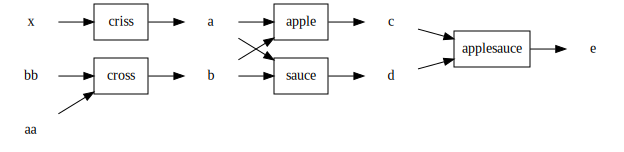

In [273]:
testdag.dot_digraph(start_lines='rankdir=LR')

In [274]:
Sig(testdag)

<Sig (x, aa, bb)>

In [275]:
#>>> d = dag_factory(aa=1, aaa=2)
>>> d = dag_factory(x=12)

>>> print(f"{i2.Sig(d)}")



(b)


In [276]:
>>> d(b='bananna')


'applesauce(c=apple(a=criss(x=12), b=bananna), d=sauce(a=criss(x=12), b=bananna))'

In [ ]:
dag+learn_model(model=LogNormal())
dag+apply_model(model=fited_model)

In [48]:
r

array([ 0.30008895,  0.63377327,  2.58933596,  1.28489352,  1.5439871 ,
        1.7813374 ,  0.7481105 ,  2.05711125,  3.06929734,  1.88943967,
        1.26870851,  4.31143707,  0.4371845 , 21.17028213,  0.43208076,
        0.55848917,  0.21323661,  0.66321053,  0.32517112,  0.99039905,
        0.8135771 ,  0.18103119,  1.89388312,  1.75481054,  4.1040609 ,
        5.38216167,  1.15281538,  2.25462395,  0.91812156,  1.73346444,
        0.46311586,  6.99140239,  0.50883173,  0.68473632,  0.34882604,
        1.78449454,  0.63313753,  0.70919382,  1.16488211,  0.98018863,
        0.44415843,  2.16742812,  4.381121  ,  1.5894543 ,  1.06879064,
        0.53818791,  0.84779992,  3.41063562,  0.70323966,  1.67336358,
        4.78222152,  1.10074239,  0.88286673,  1.37912848,  0.60186234,
        1.50211444,  0.29718621,  1.76883867,  0.30689094,  0.6840163 ,
        0.59927519,  0.48458411,  2.03834819,  0.61534514,  1.30313612,
        0.24867303,  0.72671637,  2.20950508,  1.94527105,  0.06

In [60]:
r.reshape(-1,1)

array([[ 0.30008895],
       [ 0.63377327],
       [ 2.58933596],
       [ 1.28489352],
       [ 1.5439871 ],
       [ 1.7813374 ],
       [ 0.7481105 ],
       [ 2.05711125],
       [ 3.06929734],
       [ 1.88943967],
       [ 1.26870851],
       [ 4.31143707],
       [ 0.4371845 ],
       [21.17028213],
       [ 0.43208076],
       [ 0.55848917],
       [ 0.21323661],
       [ 0.66321053],
       [ 0.32517112],
       [ 0.99039905],
       [ 0.8135771 ],
       [ 0.18103119],
       [ 1.89388312],
       [ 1.75481054],
       [ 4.1040609 ],
       [ 5.38216167],
       [ 1.15281538],
       [ 2.25462395],
       [ 0.91812156],
       [ 1.73346444],
       [ 0.46311586],
       [ 6.99140239],
       [ 0.50883173],
       [ 0.68473632],
       [ 0.34882604],
       [ 1.78449454],
       [ 0.63313753],
       [ 0.70919382],
       [ 1.16488211],
       [ 0.98018863],
       [ 0.44415843],
       [ 2.16742812],
       [ 4.381121  ],
       [ 1.5894543 ],
       [ 1.06879064],
       [ 0

In [70]:
from sklearn.preprocessing import StandardScaler
#data = [[0, 0], [0, 0], [1, 1], [1, 1]]
scaler = StandardScaler()
#scaler.fit(r[:100].reshape(-1,1))
r = np.log(r).reshape(-1,1) 
arr = [r[:200],r[200:500],r[500:1000]]
for item in arr:
    scaler.partial_fit(item)

In [71]:
vars(scaler)

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'n_features_in_': 1,
 'n_samples_seen_': 1000,
 'mean_': array([-0.02673342]),
 'var_': array([0.94109284]),
 'scale_': array([0.9700994])}

In [52]:
vars(scaler)

{'with_mean': True,
 'with_std': True,
 'copy': True,
 'n_features_in_': 1,
 'n_samples_seen_': 1000,
 'mean_': array([-0.02673342]),
 'var_': array([0.94109284]),
 'scale_': array([0.9700994])}

In [56]:
LogNormal().fit(r).sigma**2

0.9410928421250492

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


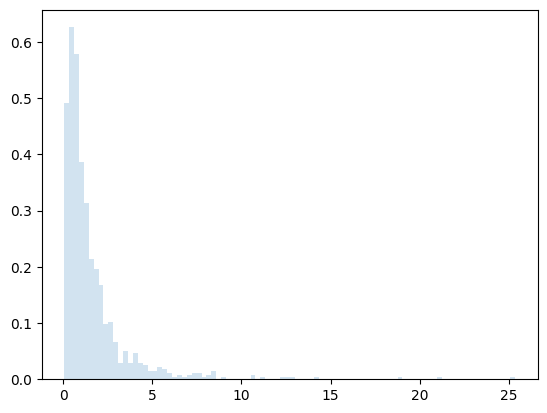

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
#ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)
plt.show()